In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from tabulate import tabulate
from scipy.stats import ttest_ind

In [2]:
# Load the uploaded CSV file
file_path = 'HF.csv'
data = pd.read_csv(file_path)

# Display the head of the DataFrame
data.head()

,date,Convertible.Arbitrage,CTA.Global,Distressed.Securities,Emerging.Markets,Equity.Market.Neutral,Event.Driven,Fixed.Income.Arbitrage,Global.Macro,Long.Short.Equity,Merger.Arbitrage,Relative.Value,Short.Selling,Funds.Of.Funds
0,1997-01-31,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1,1997-02-28,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
2,1997-03-31,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
3,1997-04-30,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
4,1997-05-31,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


In [3]:
# Extract the start and end dates from dataframe
start_date = data['date'].min()
end_date = data['date'].max()

# Fetch the historical data for S&P 500 (using 'SPY' for the S&P 500 ETF)
spy_data = yf.download('SPY', start=start_date, end=end_date, progress=False)

# Resample the data to monthly and get the last data of each month
spy_monthly = spy_data['Adj Close'].resample('M').last()

# Calculate monthly returns
spy_monthly_returns = spy_monthly.pct_change().fillna(0)

# Align the dates with existing dataframe
data['SPY'] = data['date'].apply(lambda x: spy_monthly_returns.get(x, 0))

In [4]:
# Define a function to subtract 0.04/12 from numeric values
def subtract_numeric(x):
    if isinstance(x, (int, float)):
        return x - 0.04/12
    else:
        return x

# Apply the function to the entire DataFrame
data = data.applymap(subtract_numeric)

,Intercept t-stat,Intercept p-value,Coefficient t-stat,Coefficient p-value,Intercept,Coefficient,D’Agostino’s K2 Statistic,D’Agostino’s K2 p-value
Convertible.Arbitrage,1.64,0.103,8.1,2.11e-14,0.00151,0.175,129,7.8e-29
CTA.Global,0.579,0.563,-0.742,0.459,0.000837,-0.0252,1.04,0.595
Distressed.Securities,3.19,0.00161,12.3,1.06e-27,0.00268,0.243,16.7,0.000239
Emerging.Markets,0.655,0.513,14,1.48e-33,0.000999,0.501,34,4.09e-08
Equity.Market.Neutral,1.87,0.0623,7.47,1.19e-12,0.000857,0.0803,147,1.19e-32
Event.Driven,2.66,0.00827,16.6,1.28e-42,0.00193,0.282,23.3,8.6e-06
Fixed.Income.Arbitrage,1.04,0.298,5.26,3.03e-07,0.00071,0.084,262,1.43e-57
Global.Macro,1.82,0.0697,7.58,6.15e-13,0.00151,0.147,58.1,2.4e-13
Long.Short.Equity,2.07,0.0398,20.3,1.17e-55,0.00159,0.367,64.9,8.19e-15
Merger.Arbitrage,3.12,0.00201,11.3,1.68e-24,0.00152,0.13,22.4,1.38e-05


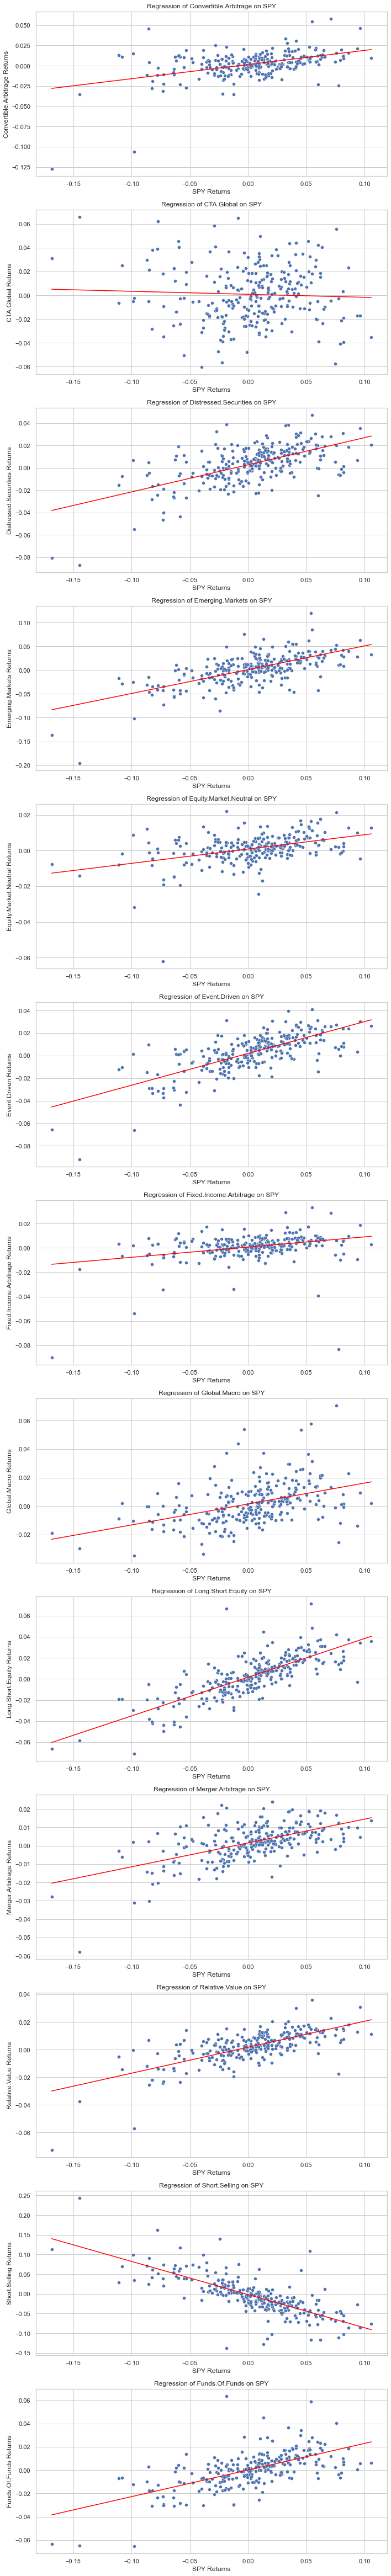

In [5]:
# Assuming 'SPY' column exists in the dataframe and represents the S&P 500 returns
spy_column = 'SPY'

# List of other strategy columns
strategy_columns = [col for col in data.columns if col not in ['date', spy_column]]

# Store regression results
regression_results = {}

# Plotting settings
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=len(strategy_columns), figsize=(10, 5 * len(strategy_columns)))

# Perform regression for each strategy and store results
for i, strategy in enumerate(strategy_columns):
    # Prepare the data for regression
    X = data[spy_column].values
    y = data[strategy].values

    # Add a constant to the predictor variable
    X = sm.add_constant(X)

    # Perform the regression
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate residuals
    residuals = y - results.predict()

    # Perform Shapiro-Wilk test
    shapiro_test = stats.shapiro(residuals)

    # Perform D'Agostino's K-squared test
    dagostino_test = stats.normaltest(residuals)

    # Store the regression and normality test results
    regression_results[strategy] = {
        'Intercept t-stat': results.tvalues[0],
        'Intercept p-value': results.pvalues[0],
        'Coefficient t-stat': results.tvalues[1],
        'Coefficient p-value': results.pvalues[1],
        'Intercept': results.params[0],  # Intercept coefficient
        'Coefficient': results.params[1],  # Regression coefficient
        'D’Agostino’s K2 Statistic': dagostino_test.statistic,
        'D’Agostino’s K2 p-value': dagostino_test.pvalue
    }

    # Plot
    sns.scatterplot(x=data[spy_column], y=data[strategy], ax=axes[i])
    sns.lineplot(x=data[spy_column], y=results.predict(), color='red', ax=axes[i])
    axes[i].set_title(f'Regression of {strategy} on SPY')
    axes[i].set_xlabel('SPY Returns')
    axes[i].set_ylabel(f'{strategy} Returns')

plt.tight_layout()

# Create a DataFrame from the regression_results dictionary
results_df = pd.DataFrame.from_dict(regression_results, orient='index')

def format_three_sig_figs(x):
    """Format a number to three significant figures."""
    return '{:.3g}'.format(x)

# Apply the formatting function to the DataFrame
formatted_results_df = results_df.applymap(format_three_sig_figs)

# Display the formatted DataFrame
formatted_results_df

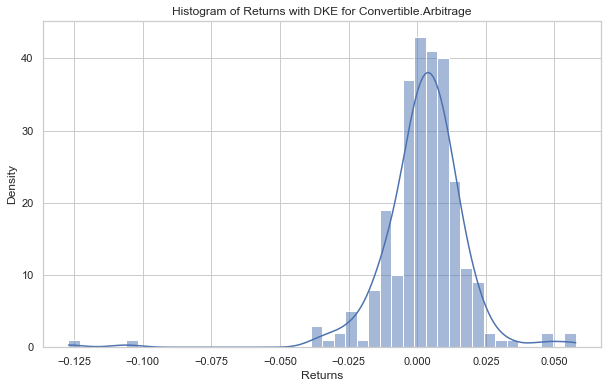

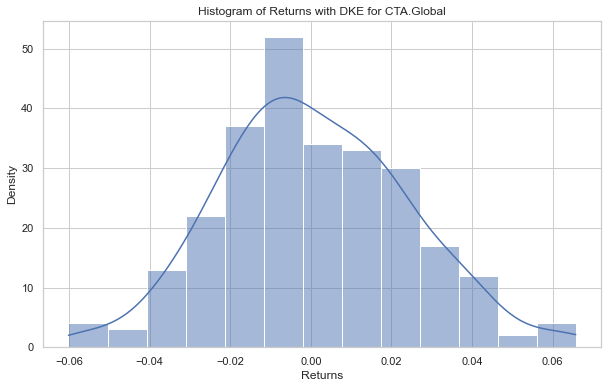

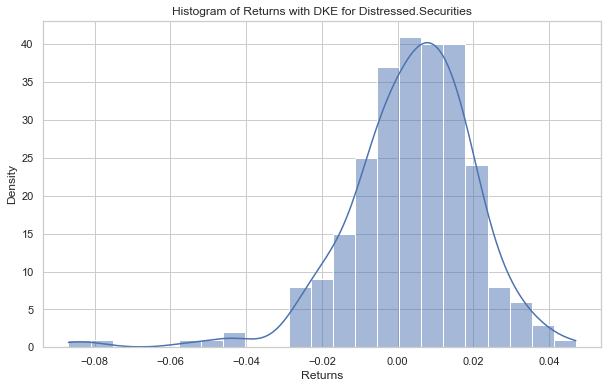

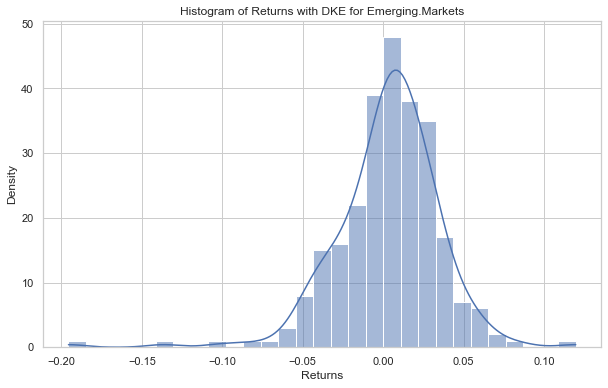

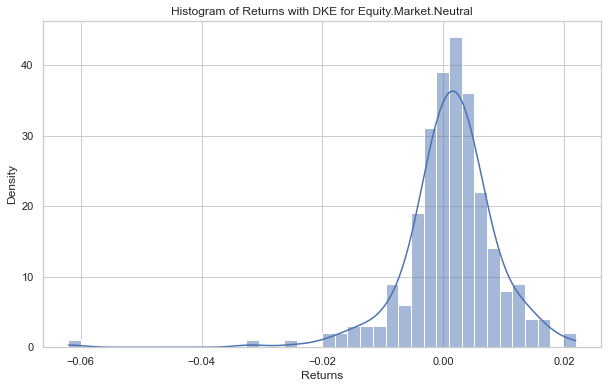

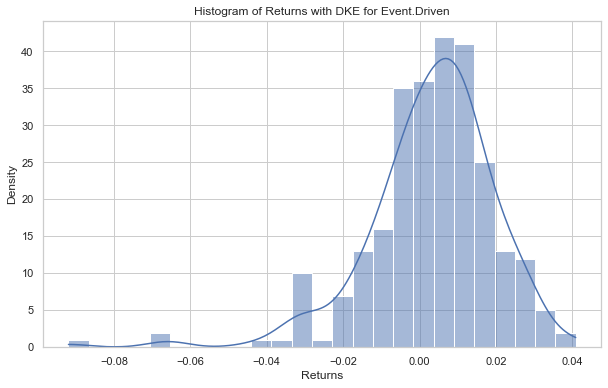

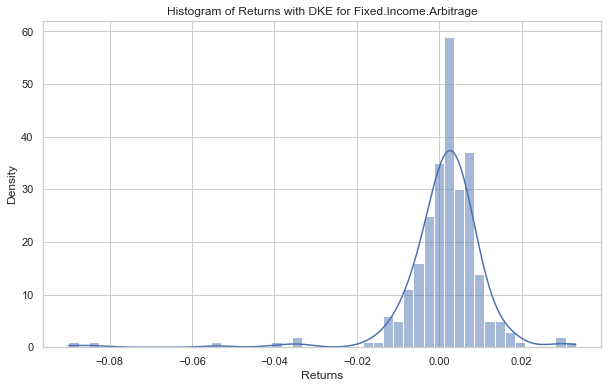

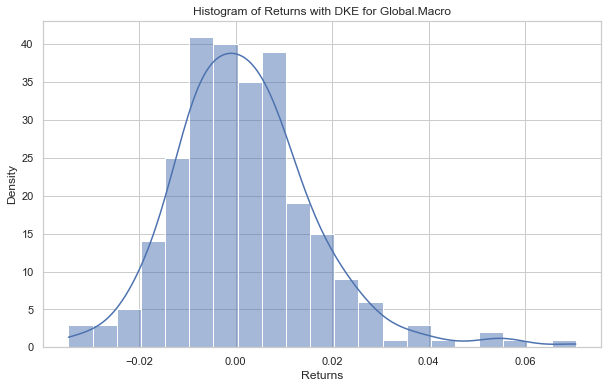

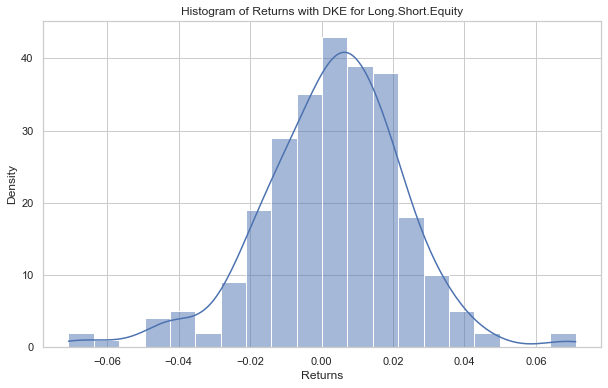

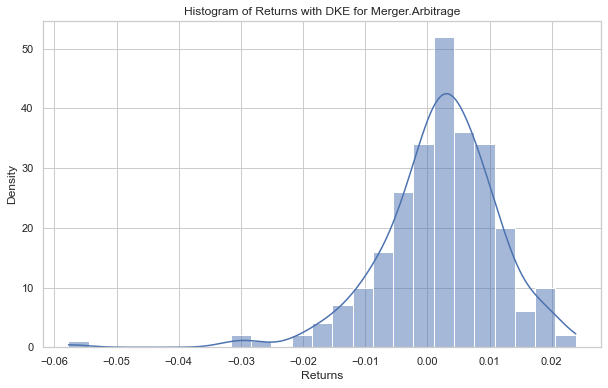

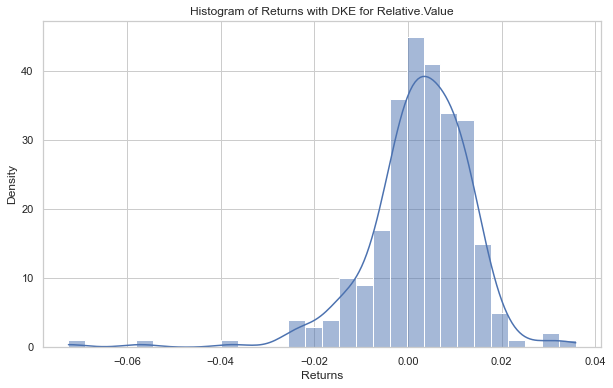

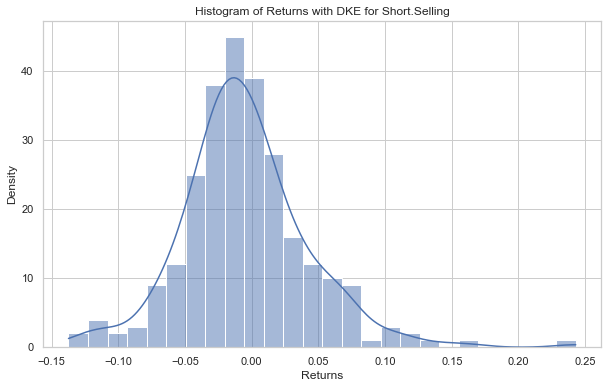

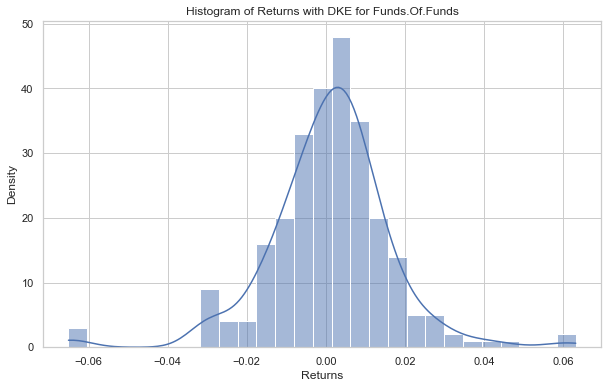

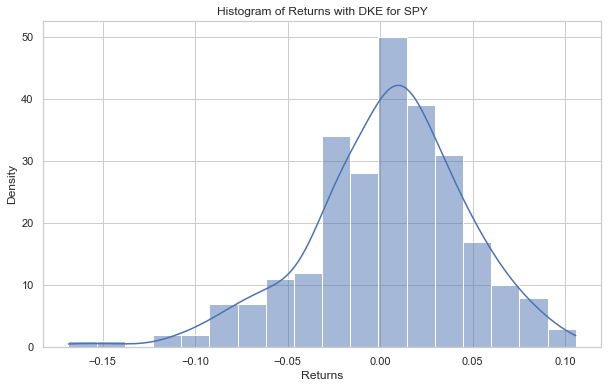

In [6]:
# Setting up the plot
sns.set(style="whitegrid")

# Plotting histograms with DKEs for each strategy
for col in data.columns:
    if col != 'date':
        plt.figure(figsize=(10, 6))
        sns.histplot(data[col], kde=True)
        plt.title(f'Histogram of Returns with DKE for {col}')
        plt.xlabel('Returns')
        plt.ylabel('Density')
        plt.show()

C:\Users\lihon\AppData\Local\Temp/ipykernel_17988/274539366.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plotting[col] = (1 + data_plotting[col]).cumprod()


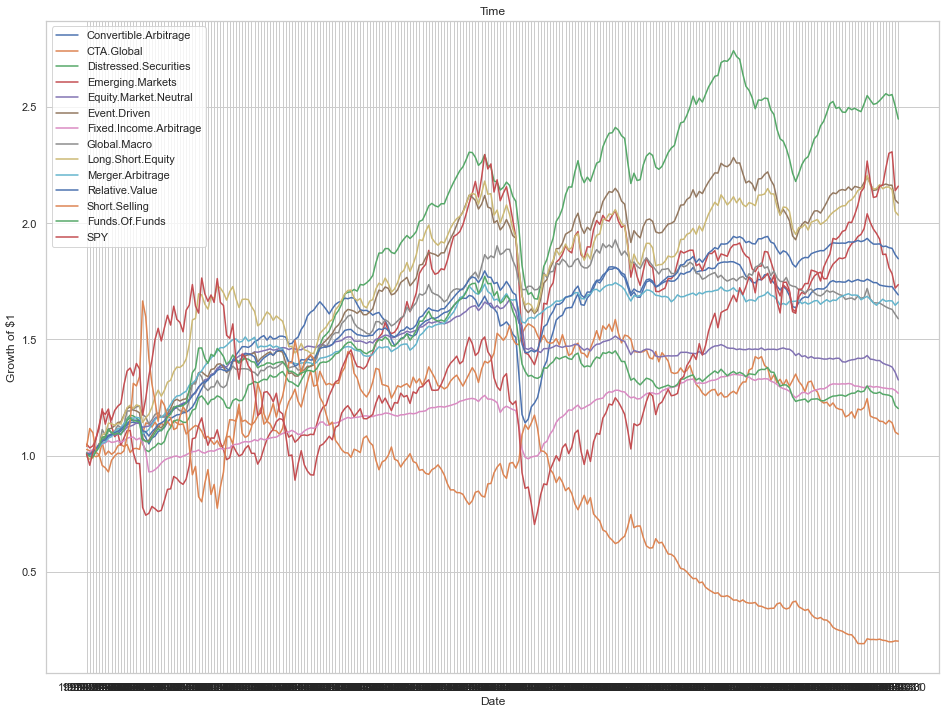

In [7]:
# Skip the first period where SPY returns are 0
data_plotting = data.iloc[1:]

# Calculate cumulative returns
for col in data_plotting.columns:
    if col != 'date':
        # Convert monthly returns to growth of $1 investment
        data_plotting[col] = (1 + data_plotting[col]).cumprod()

# Plotting the growth of $1
plt.figure(figsize=(16, 12))
for col in data_plotting.columns:
    if col != 'date':
        plt.plot(data_plotting['date'], data_plotting[col], label=col)

plt.title('Time')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.show()

In [8]:
# Extract the final values for each strategy
final_values = data_plotting.iloc[-1]

# Remove the 'date' entry
final_values = final_values.drop('date')

# Sort the strategies by their final values
ranked_strategies = final_values.sort_values(ascending=False)

# Create a DataFrame from the ranked strategies
ranked_strategies_df = pd.DataFrame({'Strategy': ranked_strategies.index, 'Final Value': ranked_strategies.values})

# Display the ranked strategies in a nice table
table = tabulate(ranked_strategies_df, headers='keys', tablefmt='fancy_grid', showindex=False)

print(table)

╒════════════════════════╤═══════════════╕
│ Strategy               │   Final Value │
╞════════════════════════╪═══════════════╡
│ Distressed.Securities  │      2.44902  │
├────────────────────────┼───────────────┤
│ SPY                    │      2.16009  │
├────────────────────────┼───────────────┤
│ Event.Driven           │      2.08719  │
├────────────────────────┼───────────────┤
│ Long.Short.Equity      │      2.03527  │
├────────────────────────┼───────────────┤
│ Relative.Value         │      1.8475   │
├────────────────────────┼───────────────┤
│ Emerging.Markets       │      1.73615  │
├────────────────────────┼───────────────┤
│ Convertible.Arbitrage  │      1.69201  │
├────────────────────────┼───────────────┤
│ Merger.Arbitrage       │      1.66133  │
├────────────────────────┼───────────────┤
│ Global.Macro           │      1.58913  │
├────────────────────────┼───────────────┤
│ Equity.Market.Neutral  │      1.32573  │
├────────────────────────┼───────────────┤
│ Fixed.Inc

In [9]:
# Assuming the 'data' DataFrame contains the monthly returns for each strategy

# Calculate Sharpe Ratios
# Sharpe Ratio = (Mean Return - Risk-Free Rate) / Standard Deviation of Return
# Assuming a risk-free rate of 0 for simplicity, as it's not provided in the dataset

sharpe_ratios = {}
for col in data.columns:
    if col != 'date':
        mean_return = data[col].mean()
        std_dev = data[col].std()
        sharpe_ratio = mean_return / std_dev if std_dev != 0 else 0
        sharpe_ratios[col] = sharpe_ratio

# Sort strategies by Sharpe Ratio
ranked_sharpe_ratios = {k: v for k, v in sorted(sharpe_ratios.items(), key=lambda item: item[1], reverse=True)}

# Create a DataFrame from the ranked Sharpe Ratios
ranked_sharpe_ratios_df = pd.DataFrame({'Strategy': list(ranked_sharpe_ratios.keys()), 'Sharpe Ratio': list(ranked_sharpe_ratios.values())})

# Display the ranked Sharpe Ratios in a nice table
table = tabulate(ranked_sharpe_ratios_df, headers='keys', tablefmt='fancy_grid', showindex=False)

print(table)

╒════════════════════════╤════════════════╕
│ Strategy               │   Sharpe Ratio │
╞════════════════════════╪════════════════╡
│ Relative.Value         │      0.214099  │
├────────────────────────┼────────────────┤
│ Distressed.Securities  │      0.211991  │
├────────────────────────┼────────────────┤
│ Merger.Arbitrage       │      0.210272  │
├────────────────────────┼────────────────┤
│ Event.Driven           │      0.17984   │
├────────────────────────┼────────────────┤
│ Long.Short.Equity      │      0.150363  │
├────────────────────────┼────────────────┤
│ Equity.Market.Neutral  │      0.143263  │
├────────────────────────┼────────────────┤
│ Global.Macro           │      0.140586  │
├────────────────────────┼────────────────┤
│ Convertible.Arbitrage  │      0.131283  │
├────────────────────────┼────────────────┤
│ SPY                    │      0.0902043 │
├────────────────────────┼────────────────┤
│ Emerging.Markets       │      0.0897395 │
├────────────────────────┼──────

In [10]:
# Function to calculate the Probabilistic Sharpe Ratio (PSR)
def probabilistic_sharpe_ratio(estimated_sharpe, benchmark_sharpe, sample_length, skewness=0, kurtosis=3):
    """
    Calculate the Probabilistic Sharpe Ratio (PSR) of a strategy.
    
    :param estimated_sharpe: The estimated Sharpe Ratio of the strategy
    :param benchmark_sharpe: The Sharpe Ratio of the benchmark
    :param sample_length: The length of the return sample
    :param skewness: The skewness of the return distribution (default 0)
    :param kurtosis: The kurtosis of the return distribution (default 3, normal distribution)
    :return: The Probabilistic Sharpe Ratio
    """

    # Calculating the test statistic
    test_stat = (estimated_sharpe - benchmark_sharpe) * (sample_length - 1) ** 0.5 / (1 - skewness * estimated_sharpe + (kurtosis - 1) * estimated_sharpe ** 2 / 4) ** 0.5

    # Calculating the PSR
    psr = stats.norm.cdf(test_stat)

    return psr

In [11]:
# Benchmark Sharpe Ratio
benchmark_sharpe = 0.1

# Calculating the PSR for each strategy
psr_values = {}
for col in data.columns:
    if col != 'date':
        mean_return = data[col].mean()
        std_dev = data[col].std()
        skewness = data[col].skew()
        kurtosis = data[col].kurtosis()
        
        estimated_sharpe = mean_return / std_dev if std_dev != 0 else 0
        sample_length = len(data[col])

        psr = probabilistic_sharpe_ratio(estimated_sharpe, benchmark_sharpe, sample_length, skewness, kurtosis)
        psr_values[col] = psr

# Convert the PSR values dictionary to a list of lists for tabulate
table_data = [[strategy, psr] for strategy, psr in psr_values.items()]

# Create a table using tabulate
table = tabulate(table_data, headers=["Strategy", "Probabilistic Sharpe Ratio"], tablefmt="fancy_grid")

# Display the table
print(table)

╒════════════════════════╤══════════════════════════════╕
│ Strategy               │   Probabilistic Sharpe Ratio │
╞════════════════════════╪══════════════════════════════╡
│ Convertible.Arbitrage  │                  0.663832    │
├────────────────────────┼──────────────────────────────┤
│ CTA.Global             │                  0.133877    │
├────────────────────────┼──────────────────────────────┤
│ Distressed.Securities  │                  0.942529    │
├────────────────────────┼──────────────────────────────┤
│ Emerging.Markets       │                  0.437544    │
├────────────────────────┼──────────────────────────────┤
│ Equity.Market.Neutral  │                  0.724778    │
├────────────────────────┼──────────────────────────────┤
│ Event.Driven           │                  0.872543    │
├────────────────────────┼──────────────────────────────┤
│ Fixed.Income.Arbitrage │                  0.442544    │
├────────────────────────┼──────────────────────────────┤
│ Global.Macro

In [12]:
# Benchmark Sharpe Ratio
benchmark_sharpe = 0.2

# Calculating the PSR for each strategy
psr_values = {}
for col in data.columns:
    if col != 'date':
        mean_return = data[col].mean()
        std_dev = data[col].std()
        skewness = data[col].skew()
        kurtosis = data[col].kurtosis()
        
        estimated_sharpe = mean_return / std_dev if std_dev != 0 else 0
        sample_length = len(data[col])

        psr = probabilistic_sharpe_ratio(estimated_sharpe, benchmark_sharpe, sample_length, skewness, kurtosis)
        psr_values[col] = psr

# Convert the PSR values dictionary to a list of lists for tabulate
table_data = [[strategy, psr] for strategy, psr in psr_values.items()]

# Create a table using tabulate
table = tabulate(table_data, headers=["Strategy", "Probabilistic Sharpe Ratio"], tablefmt="fancy_grid")

# Display the table
print(table)

╒════════════════════════╤══════════════════════════════╕
│ Strategy               │   Probabilistic Sharpe Ratio │
╞════════════════════════╪══════════════════════════════╡
│ Convertible.Arbitrage  │                  0.176436    │
├────────────────────────┼──────────────────────────────┤
│ CTA.Global             │                  0.00315133  │
├────────────────────────┼──────────────────────────────┤
│ Distressed.Securities  │                  0.567016    │
├────────────────────────┼──────────────────────────────┤
│ Emerging.Markets       │                  0.0455832   │
├────────────────────────┼──────────────────────────────┤
│ Equity.Market.Neutral  │                  0.216795    │
├────────────────────────┼──────────────────────────────┤
│ Event.Driven           │                  0.386872    │
├────────────────────────┼──────────────────────────────┤
│ Fixed.Income.Arbitrage │                  0.0656374   │
├────────────────────────┼──────────────────────────────┤
│ Global.Macro

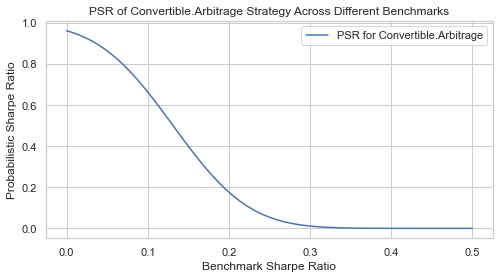

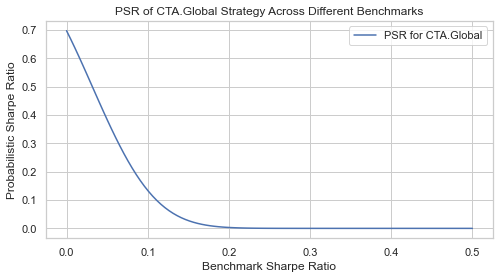

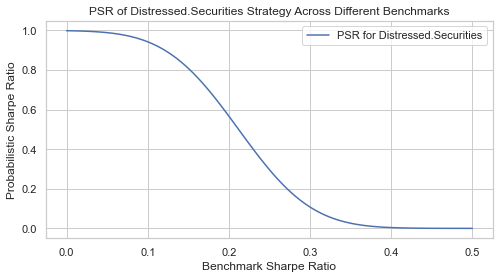

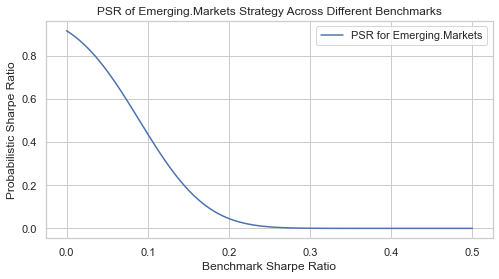

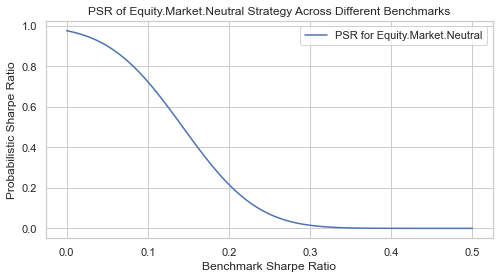

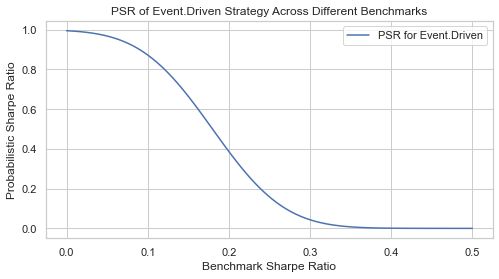

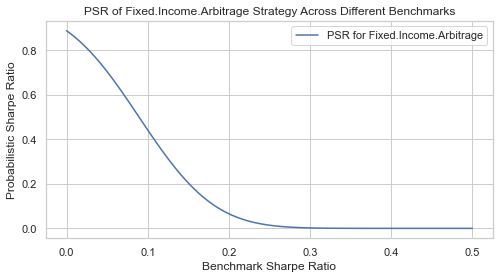

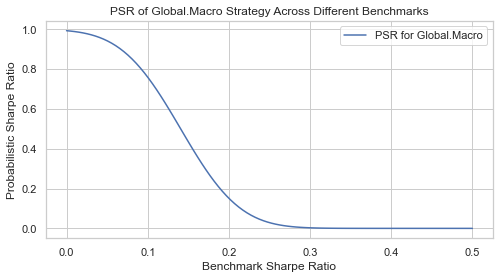

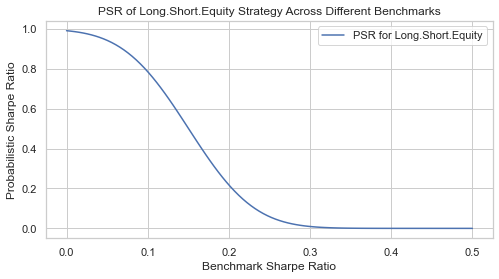

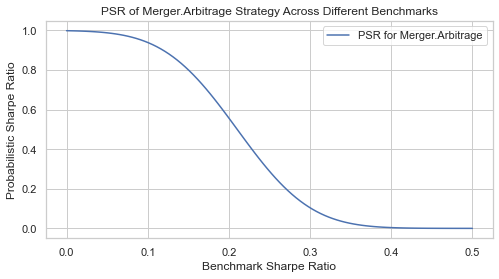

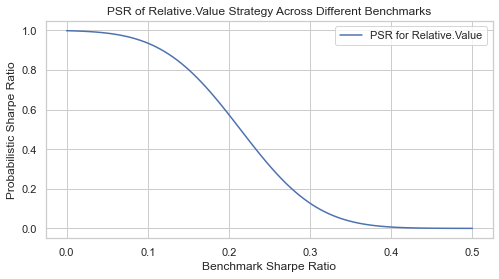

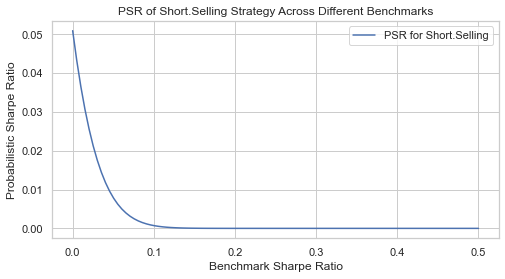

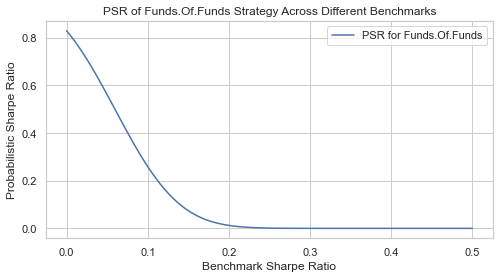

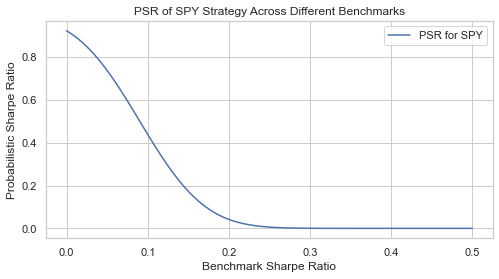

In [13]:
# Benchmark Sharpe Ratios for the x-axis
benchmark_sharpes = np.linspace(0, 0.5, 100)

# Plotting PSR against various benchmark Sharpes for each strategy
for col in data.columns:
    if col != 'date':
        mean_return = data[col].mean()
        std_dev = data[col].std()
        skewness = data[col].skew()
        kurtosis = data[col].kurtosis()
        
        estimated_sharpe = mean_return / std_dev if std_dev != 0 else 0
        sample_length = len(data[col])

        # Calculating PSR for different benchmarks
        psr_values = [probabilistic_sharpe_ratio(estimated_sharpe, b_sharpe, sample_length, skewness, kurtosis) for b_sharpe in benchmark_sharpes]

        # Plotting
        plt.figure(figsize=(8, 4))
        plt.plot(benchmark_sharpes, psr_values, label=f'PSR for {col}')
        plt.xlabel('Benchmark Sharpe Ratio')
        plt.ylabel('Probabilistic Sharpe Ratio')
        plt.title(f'PSR of {col} Strategy Across Different Benchmarks')
        plt.legend()
        plt.show()

In [14]:
# Function to calculate the differential of 1 - PSR, representing the PDF of Sharpe Ratios
def sharpe_ratio_pdf(estimated_sharpe, sample_length, skewness=0, kurtosis=3, benchmark_sharpes=np.linspace(0, 0.5, 100)):
    """
    Calculate the PDF of Sharpe Ratios for a strategy.

    :param estimated_sharpe: The estimated Sharpe Ratio of the strategy
    :param sample_length: The length of the return sample
    :param skewness: The skewness of the return distribution (default 0)
    :param kurtosis: The kurtosis of the return distribution (default 3, normal distribution)
    :param benchmark_sharpes: Array of benchmark Sharpe Ratios to evaluate
    :return: The PDF values for each benchmark Sharpe Ratio
    """
    psr_values = np.array([probabilistic_sharpe_ratio(estimated_sharpe, b_sharpe, sample_length, skewness, kurtosis) for b_sharpe in benchmark_sharpes])
    pdf_values = np.gradient(1 - psr_values, benchmark_sharpes)
    return pdf_values

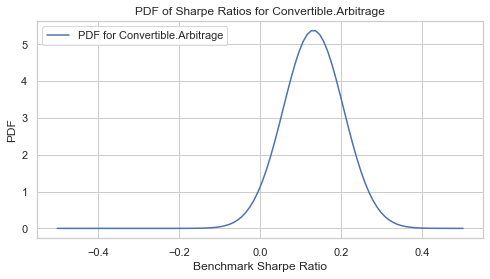

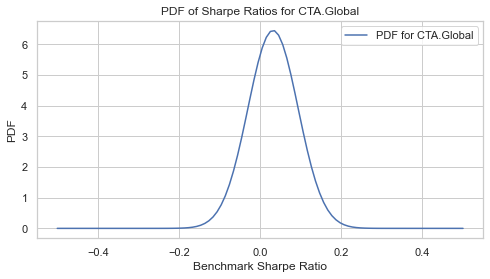

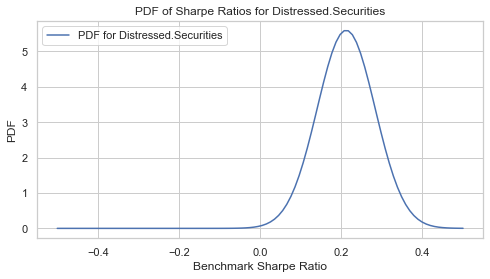

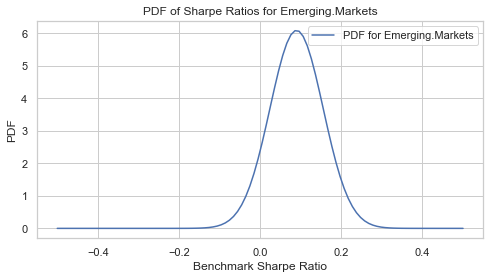

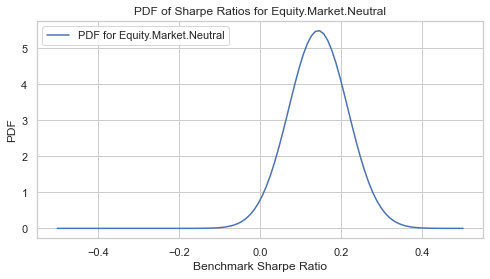

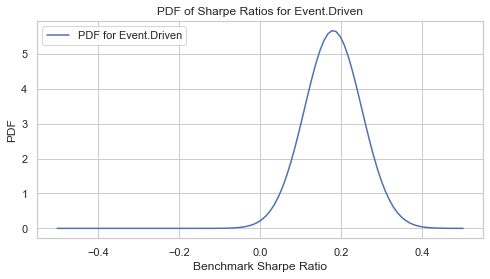

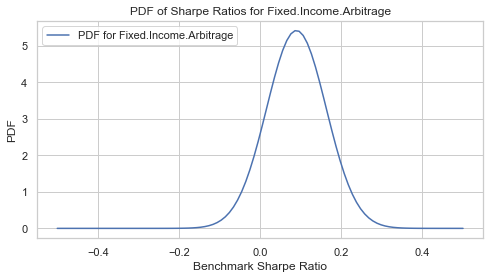

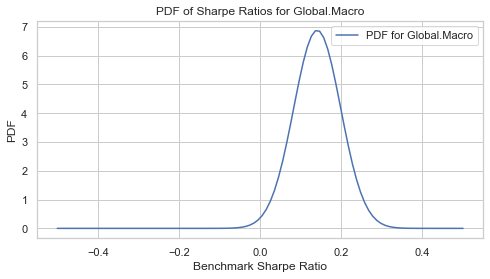

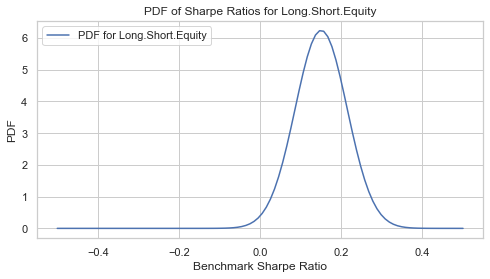

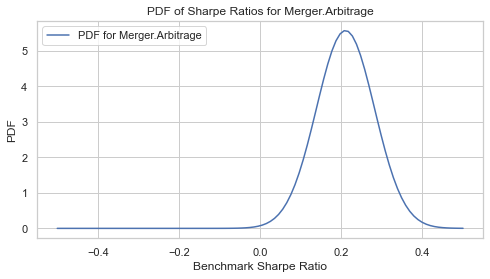

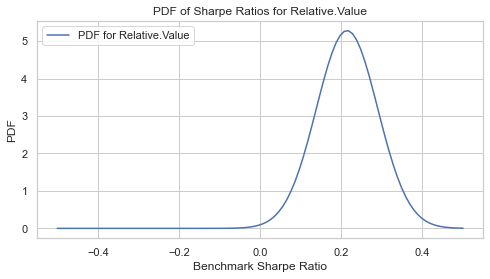

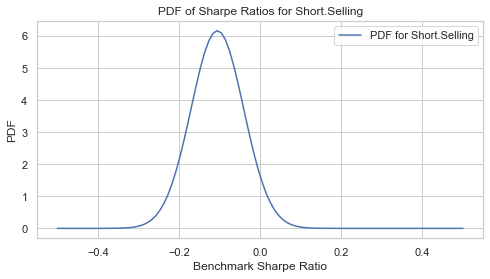

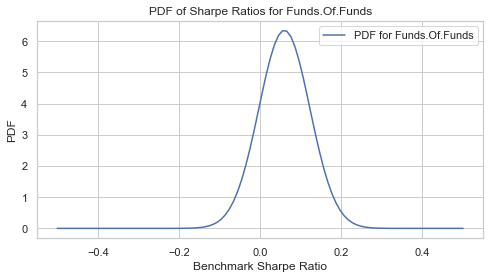

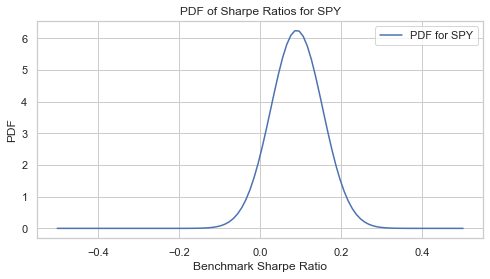

In [15]:
# Calculate and plot the PDF of Sharpe Ratios for each strategy
for col in data.columns:
    if col != 'date':
        mean_return = data[col].mean()
        std_dev = data[col].std()
        skewness = data[col].skew()
        kurtosis = data[col].kurtosis()
        
        estimated_sharpe = mean_return / std_dev if std_dev != 0 else 0
        sample_length = len(data[col])

        # Calculating the PDF of Sharpe Ratios
        benchmark_sharpes = np.linspace(-0.5, 0.5, 100)
        pdf_values = sharpe_ratio_pdf(estimated_sharpe, sample_length, skewness, kurtosis, benchmark_sharpes)

        # Plotting the PDF
        plt.figure(figsize=(8, 4))
        plt.plot(benchmark_sharpes, pdf_values, label=f'PDF for {col}')
        plt.xlabel('Benchmark Sharpe Ratio')
        plt.ylabel('PDF')
        plt.title(f'PDF of Sharpe Ratios for {col}')
        plt.legend()
        plt.show()

In [21]:
# Calculate PDF of Sharpe Ratios for SPY
mean_return_spy = data['SPY'].mean()
std_dev_spy = data['SPY'].std()
skewness_spy = data['SPY'].skew()
kurtosis_spy = data['SPY'].kurtosis()
estimated_sharpe_spy = mean_return_spy / std_dev_spy if std_dev_spy != 0 else 0
sample_length_spy = len(data['SPY'])
pdf_spy = sharpe_ratio_pdf(estimated_sharpe_spy, sample_length_spy, skewness_spy, kurtosis_spy)

# Perform direct test from the PDFs between each strategy and SPY
results = []
for col in data.columns:
    if col != 'date' and col != 'SPY':
        # Calculate PDF for the strategy
        mean_return = data[col].mean()
        std_dev = data[col].std()
        skewness = data[col].skew()
        kurtosis = data[col].kurtosis()
        estimated_sharpe = mean_return / std_dev if std_dev != 0 else 0
        sample_length = len(data[col])
        pdf_strategy = sharpe_ratio_pdf(estimated_sharpe, sample_length, skewness, kurtosis)

        # Compare PDFs to determine the probability of outperformance
        probability_outperform = np.mean(pdf_strategy > pdf_spy)
        results.append([col, probability_outperform])

# Create a table using tabulate
table = tabulate(results, headers=["Strategy", "Prob[Outperfor SPY]"], tablefmt="fancy_grid")

# Display the table
print(table)

╒════════════════════════╤═══════════════════════╕
│ Strategy               │   Prob[Outperfor SPY] │
╞════════════════════════╪═══════════════════════╡
│ Convertible.Arbitrage  │                  0.75 │
├────────────────────────┼───────────────────────┤
│ CTA.Global             │                  0.13 │
├────────────────────────┼───────────────────────┤
│ Distressed.Securities  │                  0.69 │
├────────────────────────┼───────────────────────┤
│ Emerging.Markets       │                  0.74 │
├────────────────────────┼───────────────────────┤
│ Equity.Market.Neutral  │                  0.75 │
├────────────────────────┼───────────────────────┤
│ Event.Driven           │                  0.72 │
├────────────────────────┼───────────────────────┤
│ Fixed.Income.Arbitrage │                  0.73 │
├────────────────────────┼───────────────────────┤
│ Global.Macro           │                  0.78 │
├────────────────────────┼───────────────────────┤
│ Long.Short.Equity      │     